In [18]:
import pandas as pd
from pathlib import Path
import os

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay, balanced_accuracy_score

import sys
sys.path.append(os.path.abspath('..'))

from util import evaluate_model_performance, evaluate_model_fairness

In [3]:
data_path = Path(os.getcwd()).parent.parent / "data" / "dataset_diabetes"
df = pd.read_csv(data_path / "diabetic_preprocessed.csv")

In [4]:
df["age"] = df["age_all"]

columns_to_remove = ['encounter_id', 'patient_nbr', 'readmitted', 'readmit_binary', 'diabetes_type', \
    'had_emergency', 'had_inpatient_days', 'had_outpatient_days', 'race_all', 'age_all']

df_for_experimenting = df.drop(columns=columns_to_remove)

In [5]:
target_variable = "readmit_30_days"
Y= df_for_experimenting.loc[:, target_variable]

In [6]:
X = pd.get_dummies(df_for_experimenting.drop(columns=["readmit_30_days"]))

In [7]:
X.head() # sanity check

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Caucasian,...,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,0,0,0,1,0,1,...,1,0,1,0,1,0,0,1,1,0
1,3,59,0,18,0,0,0,9,0,1,...,1,0,1,0,1,0,1,0,0,1
2,2,11,5,13,2,0,1,6,1,0,...,1,0,1,0,1,0,0,1,0,1
3,2,44,1,16,0,0,0,7,0,1,...,1,0,1,0,1,0,1,0,0,1
4,1,51,0,8,0,0,0,5,0,1,...,1,0,1,0,1,0,1,0,0,1


In [25]:
X_wo_sensitive = pd.get_dummies(df_for_experimenting.drop(columns=["readmit_30_days", "race"]))

In [26]:
random_seed = 445
np.random.seed(random_seed)

df_train, df_test, X_train, X_test, X_train_wo_sensitive, X_test_wo_sensitive, Y_train, Y_test = train_test_split(
    df_for_experimenting,
    X,
    X_wo_sensitive,
    Y,
    test_size=0.20,
    stratify=Y,
    random_state=random_seed
)

### Train the model - dataset with sensitive attribute (race)

In [10]:
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

In [12]:
unmitigated_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [13]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

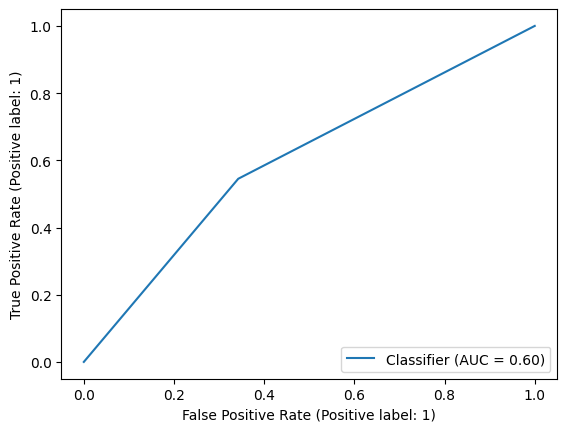

In [16]:
RocCurveDisplay.from_predictions(Y_test, Y_pred)

In [24]:
evaluate_model_performance(Y_test, Y_pred)
evaluate_model_fairness(Y_test, Y_pred, df_test['race'])

The balanced accuracy score for the testing data: 0.6013195014385029
The precision score for the testing data: 0.16659938097160543
The recall score for the testing data: 0.5451343020695729
The F1 score for the testing data: 0.2552051123479695
The F2 score for the testing data: 0.37481077808053287
The G mean score for the testing data: 0.5986888726058998
The Demographic parity difference score for the testing data: 0.20932543811133503
The Equalized odds difference score for the testing data: 0.2903292464526794
The Equal opportunity difference score for the testing data: 0.5451343020695729


c:\Users\Tanya\Desktop\TANYA\FMI\Masters\thesis\src\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

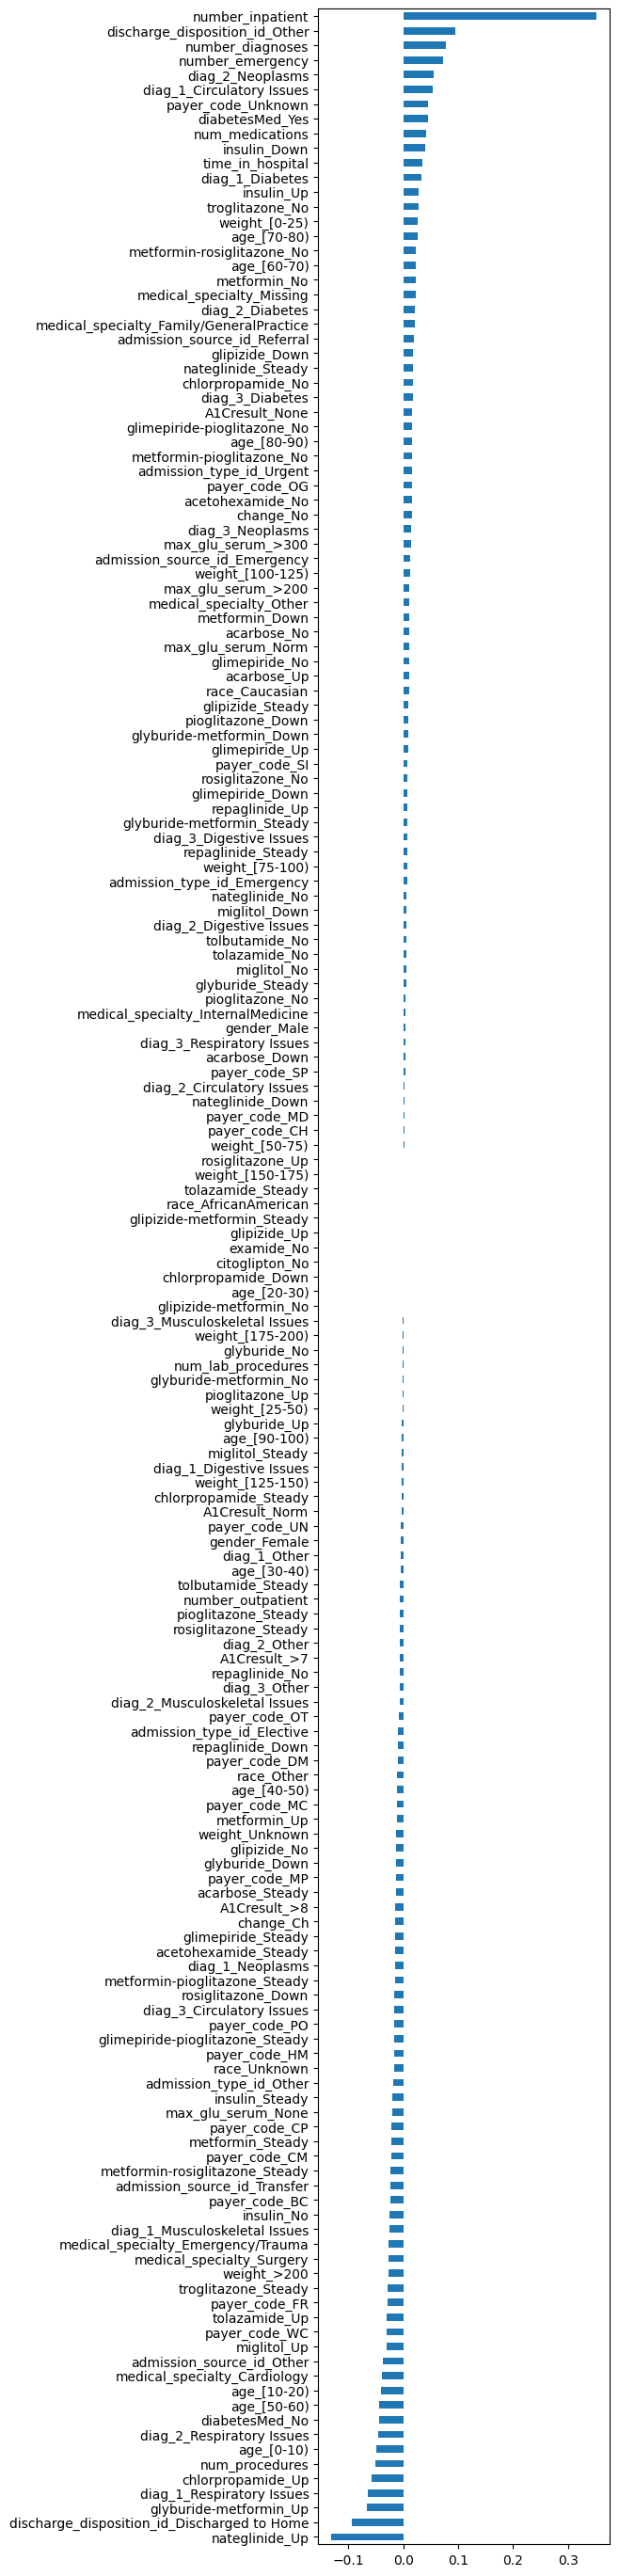

In [22]:
coef_series = pd.Series(data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0], index=X.columns)
coef_series.sort_values().plot.barh(figsize=(4, 35), legend=False)

### Train the model - dataset w/o sensitive attribute (race)

In [27]:
unmitigated_pipeline.fit(X_train_wo_sensitive, Y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [28]:
Y_pred_proba_wo_sensitive = unmitigated_pipeline.predict_proba(X_test_wo_sensitive)[:,1]
Y_pred_wo_sensitive = unmitigated_pipeline.predict(X_test_wo_sensitive)

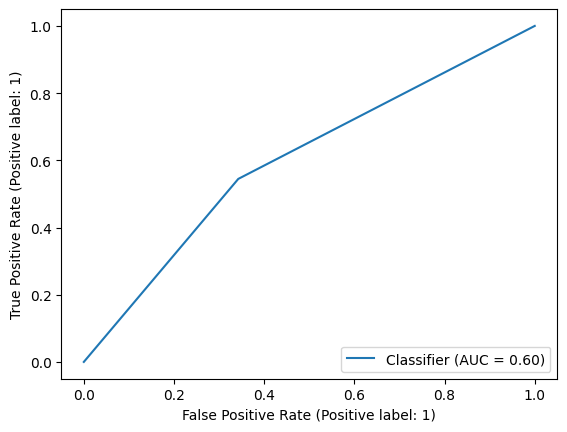

In [29]:
RocCurveDisplay.from_predictions(Y_test, Y_pred_wo_sensitive)

In [30]:
evaluate_model_performance(Y_test, Y_pred_wo_sensitive)
evaluate_model_fairness(Y_test, Y_pred_wo_sensitive, df_test['race'])

The balanced accuracy score for the testing data: 0.6010716823029059
The precision score for the testing data: 0.16646480958148296
The recall score for the testing data: 0.5446939674152356
The F1 score for the testing data: 0.2549989692846836
The F2 score for the testing data: 0.37450802300938535
The G mean score for the testing data: 0.5984218583328069
The Demographic parity difference score for the testing data: 0.12543207775581797
The Equalized odds difference score for the testing data: 0.16892911010558076
The Equal opportunity difference score for the testing data: 0.5446939674152356


c:\Users\Tanya\Desktop\TANYA\FMI\Masters\thesis\src\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

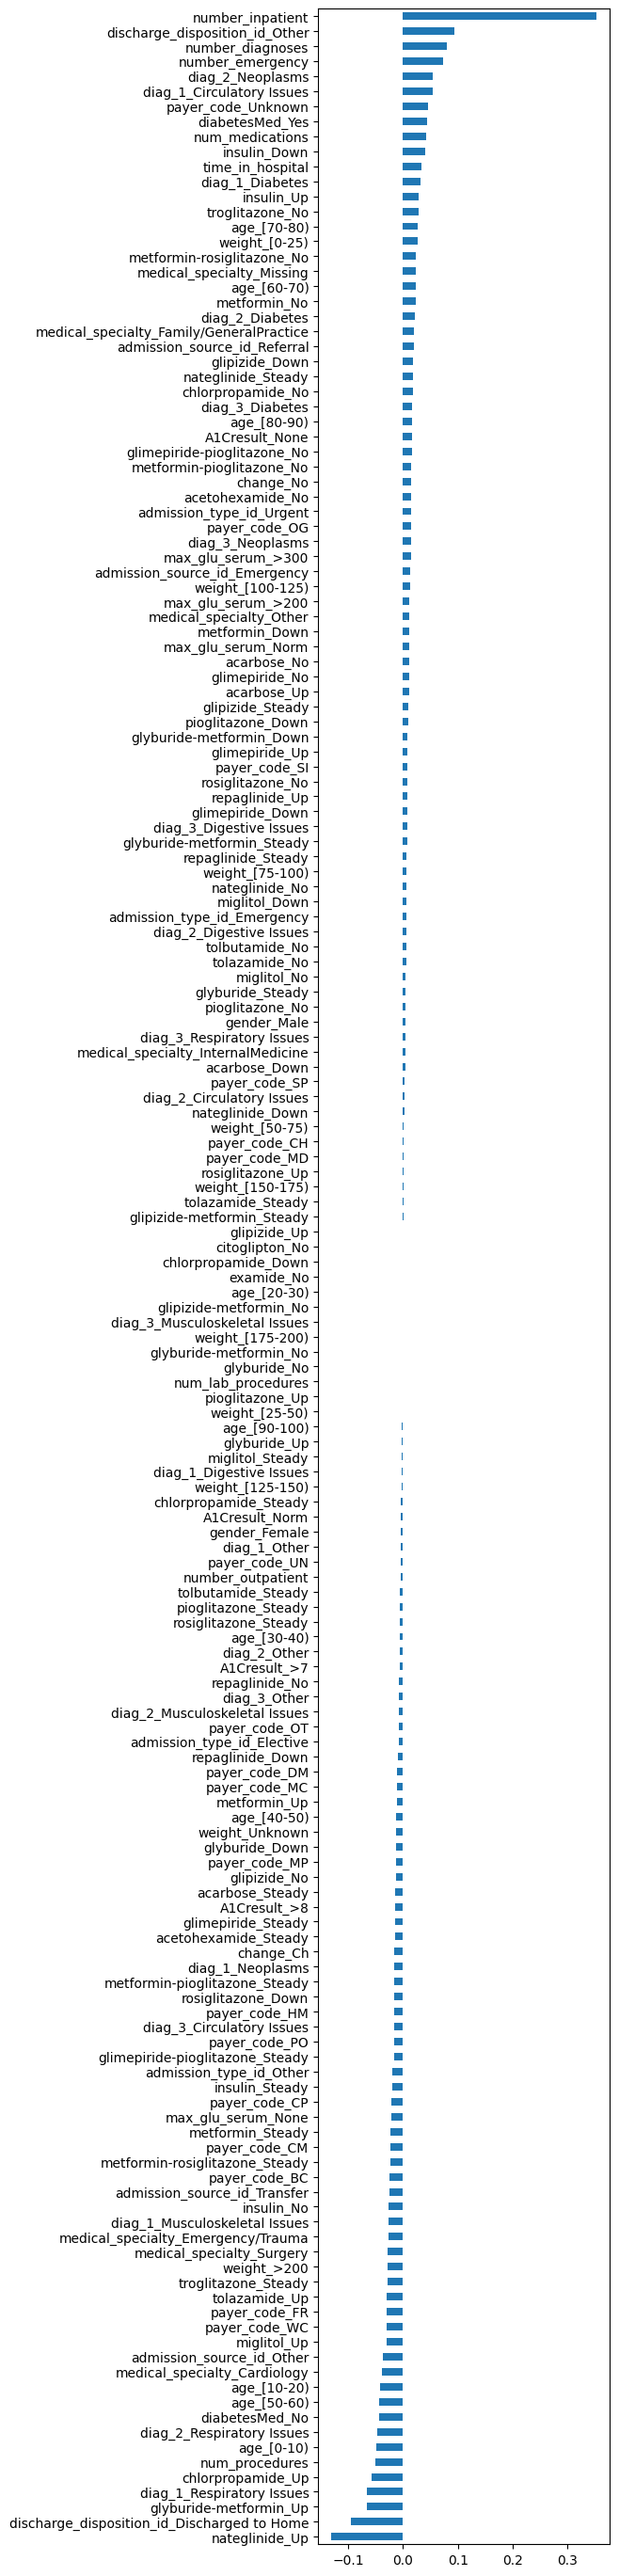

In [32]:
coef_series = pd.Series(data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0], index=X_wo_sensitive.columns)
coef_series.sort_values().plot.barh(figsize=(4, 35), legend=False)